In [57]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys 
import re
from ipynb.fs.full.utilities import *
from scipy import signal, fftpack
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import butter,filtfilt
from operator import add
# import all libraries
from matplotlib.patches import Rectangle
import math
from sklearn.neighbors import KernelDensity
import kmeans1d

In [58]:
# LOADING THE DATASET INTO A PD DATAFRAME

data = "/home/jacopo/research/NASA_dataset/2nd_test"    # it is considered the second dataset because it has only one accellerometer for each bearings
fs = 20000                                              # sampling frequency in Hz
ts = 1/fs                                               # sampling period in s
n_samples = 20480

df_list = []
for path,dirs,files in os.walk(data):
    dirs.sort(key=alphanumeric_sort)
    for file in files:
        if file.endswith('.png'):
            continue
        else:
            df = pd.read_csv(os.path.join(path,file),  sep='\t', header=None)
            df.rename(columns={0: 'ch_1', 1: 'ch_2', 2: 'ch_3', 3: 'ch_4'}, inplace = True)  # renaming the columns
            n_samples = df.shape[0]
            time = np.linspace(0, n_samples*ts, num=n_samples, endpoint=False, axis=0)
            if(df.shape[0] != 20480):
                print("different size!")       # checking that all dataseries has the same number of datapoints 
            df['time'] = time
            df_list.append(df)
            
# each dataseries has 4 accellerometer channel and one temporal channel, lasting for 1 seconds
# each time series has 20480 samples

# performed a check for guarantee that all the elements inside the list of dataframe are composed of different data

In [59]:
# FFt for each signals
n = len(df_list[0])

xf = np.fft.fftfreq(n, d=ts)[0:n//2]
yf_list = []
xf_list = []  
start_interval = 2000
finish_interval = 6000            

for elem in df_list[0].columns.values:
    yf_list_ch = []
    xf_list_ch = []

    if elem != 'time': 
        for k in range(len(df_list)):
            yf = df_list[k][elem].to_numpy()
            yf = fft(yf)[0:n//2]
            yf_abs = np.abs(yf) 
            # indices = yf_abs > (0.1*yf_abs.max())   # filter out those value under 300
            # yf_clean = indices * yf_abs
            
            yf_list_ch.append(yf_abs[start_interval:finish_interval])
            xf_list_ch.append(xf[start_interval:finish_interval])
        yf_list.append(yf_list_ch)
        xf_list.append(xf_list_ch)
        
n_samples = len(df_list[0]['ch_1'].to_numpy()[start_interval:finish_interval])
        

In [60]:
# approximation functions on the fft function + integral with variable basis lenght approximation

appr_x = []
appr_y = []
max_points = []
approx_split = 100
last_freq = xf_list[0][0][len(xf_list[0][0])-1] 
n_split = 25 # the number of split and the number of split for function approximation are different!!

print("possible divisor for equidistant intervals: {}".format(getDivs(n_samples)))

if n_split in getDivs(n_samples):
    print("selected {} splits; number of samples per split = {}".format(n_split, (finish_interval-start_interval)/n_split))
    for i in range(len(yf_list)):
        appr_x_ch = []
        appr_y_ch = []
        max_points_ch = []
        max_list = []
        partial_xf = []
        
        for j in range(len(yf_list[i])):
            ts = yf_list[i][j]
            
            split_list = np.split(ts, n_split)    # split into n equivalent intervals; each of them have the same number of samples
            max_list = [np.max(split_list[k]) for k in range(len(split_list))]
            max_list_index = [np.argmax(split_list[k]) for k in range(len(split_list))]
            track_index = int(len(yf_list[0][j])/n_split)*np.arange(n_split)
            indeces = list( map(add, max_list_index, track_index))
            partial_xf = [xf_list[0][0][i] for i in(indeces)]
            
            if(xf_list[i][j][0] not in partial_xf):
                partial_xf.insert(0, xf_list[0][0][0])
                max_list.insert(0, ts[0])
                
            if(xf_list[i][j][len(xf_list[i][j])-1] not in partial_xf):    
                partial_xf.append(xf_list[0][0][len(xf_list[0][0])-1])
                max_list.append(ts[len(ts)-1])
                         
            h_list = []
            for k in range(len(partial_xf)-1):
                h_list.append(np.abs((max_list[k+1]+max_list[k])/2))
            
            appr_x_ch.append(partial_xf)
            appr_y_ch.append(h_list)
            max_points_ch.append(max_list)

        appr_x.append(appr_x_ch)
        appr_y.append(appr_y_ch)
        max_points.append(max_points_ch)
else:
    print("invalid split")



possible divisor for equidistant intervals: [1, 2, 4, 5, 8, 10, 16, 20, 25, 32, 40, 50, 80, 100, 125, 160, 200, 250, 400, 500, 800, 1000, 2000, 4000]
selected 25 splits; number of samples per split = 160.0


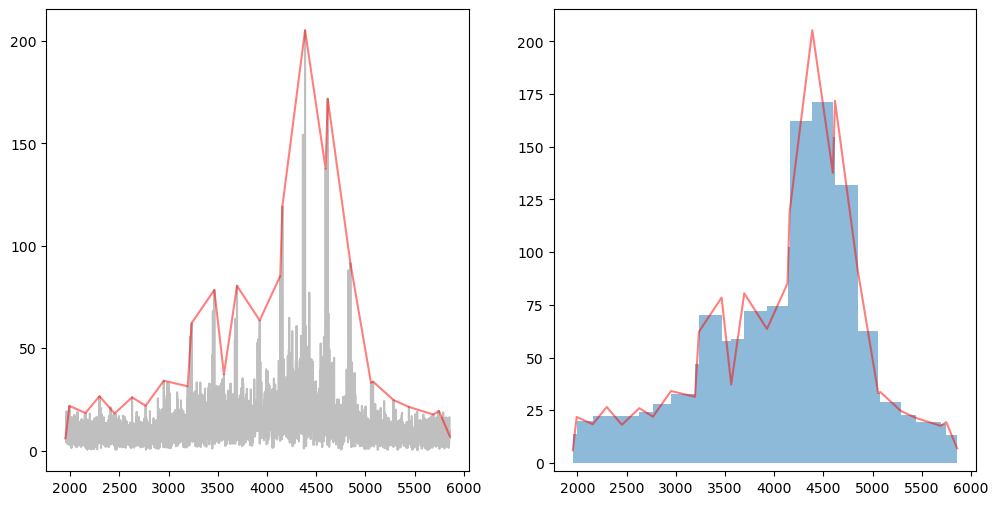

In [61]:
# test plot
prove = 590    # selection of the ts to plot 

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(xf_list[0][prove], yf_list[0][prove], color='gray', alpha=0.5)
ax[0].plot(appr_x[0][prove], max_points[0][prove], color='red', alpha=0.5)

ax[1].plot(appr_x[0][prove], max_points[0][prove], color='red', alpha=0.5)
for t in range(len(appr_x[0][prove])-1):
    ax[1].add_patch(Rectangle((appr_x[0][prove][t],0), np.abs(appr_x[0][prove][t+1]-appr_x[0][prove][t]), appr_y[0][prove][t], alpha=0.5))
    # the problem here is that the bins are defined wrt max value; we want them equidistant!!!
    # it is not suitble for operating integral difference with different function approximation
plt.show()

In [62]:
# definition of line approximation for Riemannian integral operation reconstruction 
line_list = []
for i in range(len(max_points)):
    line_ch = []
    for j in range(len(max_points[i])):
        line_ts = []
        for k in range(len(max_points[i][j])-1):
            
            x_prev = appr_x[i][j][k]
            y_prev = max_points[i][j][k]
            x_next = appr_x[i][j][k+1]
            y_next = max_points[i][j][k+1]
            
            m,q = line_coeff([x_next, y_next], [x_prev, y_prev])
            if(math.isnan(m)):
                print("i = {}, j = {}, k = {}".format(i,j,k))
                
                # print("m: {}".format(m))
                # print("q: {}".format(q))
            x_line = np.linspace(x_prev, x_next, 500)
            y_line = m*x_line + q
                    
            line_ts.append(np.array([[x_prev, x_next], [m,q]]))
        line_ch.append(line_ts)
    line_list.append(line_ch)
    
# the line are plotted correctly 


In [63]:
  # last frequency in which span the interval in the x axis 
bins_approximation = 500                       # same number used in the description of the frequency coefficients 
x_axis = np.linspace(xf_list[0][0][0], xf_list[0][0][len(xf_list[i][j])-1], bins_approximation) #(0, last_freq, bins_approximation )
y_list = []
for i in range(len(line_list)):
    y_ch = []
    for j in range(len(line_list[i])):
        y_ts = []
        for k in range(len(line_list[i][j])):
            for x_coord in x_axis: 
                if( line_list[i][j][k][0][0] <= x_coord <= line_list[i][j][k][0][1]):
                    m = line_list[i][j][k][1][0]
                    q = line_list[i][j][k][1][1]
                    if(math.isnan(m*x_coord+q)):
                        print("m: {}".format(line_list[i][j][k][1][0]))
                        print("q: {}".format(line_list[i][j][k][1][1]))
                        print("\n")
                        
                    y_ts.append(m*x_coord+q)
        y_ch.append(y_ts)
    if i == int(len(line_list)/4):
        print("25% completed")
    if i == int(len(line_list)/2):
        print("50% completed")
    if i == int(3*len(line_list)/4):
        print("75% completed")
    y_list.append(y_ch)

print("introducing trapezoidal approximation...")
y_approx = []
for i in range(len(line_list)):
    y_approx_ch = []
    for j in range(len(y_list[i])):
        y_approx_ts = []
        for k in range(len(y_list[i][j])-1):
            y_approx_ts.append(np.abs((y_list[i][j][k+1]+y_list[i][j][k])/2))
        y_approx_ch.append(y_approx_ts)
    y_approx.append(y_approx_ch)
print("process terminated")

25% completed
50% completed
75% completed
introducing trapezoidal approximation...
process terminated


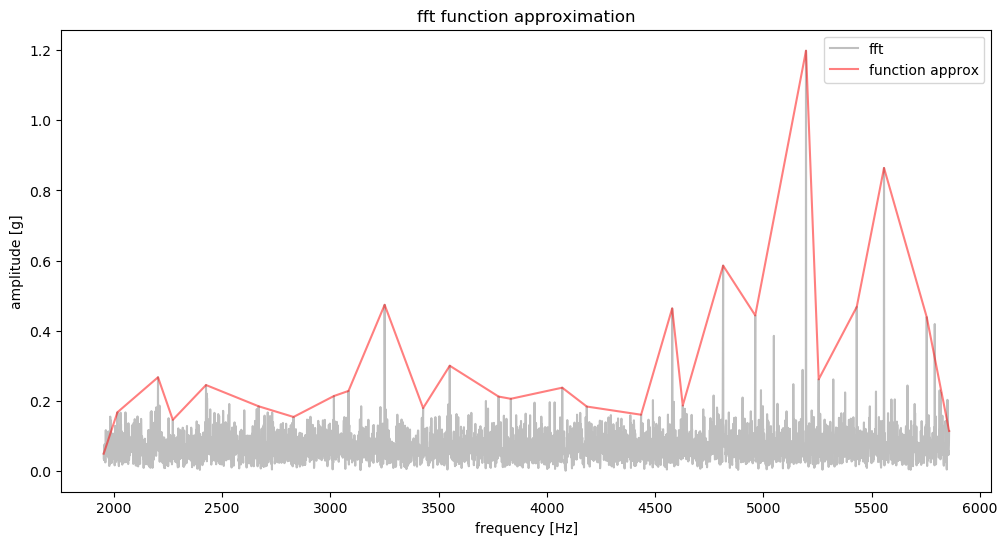

In [64]:
# testing... 
prove = 11
channel = 0
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(xf_list[channel][prove], yf_list[channel][prove], color='gray', alpha=0.5, label='fft')
ax.plot(appr_x[channel][prove], max_points[channel][prove], color='red', alpha=0.5, label='function approx')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('amplitude [g]')
ax.set_title('fft function approximation')
ax.legend()
# ax[1].plot(appr_x[channel][prove], max_points[channel][prove], color='red', alpha=0.5)
# for t in range(len(x_axis)-1):
#     ax[1].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], y_approx[channel][prove][t]))
    
plt.show()

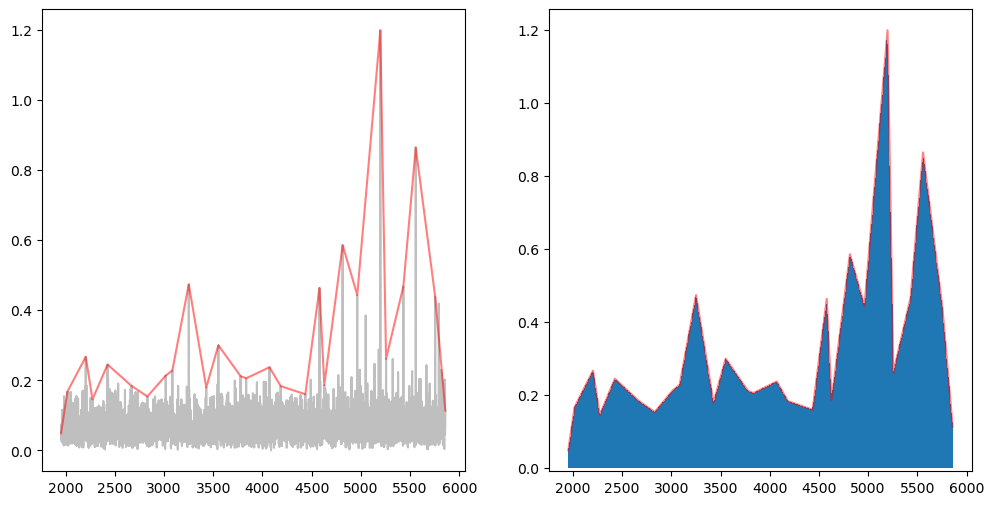

In [65]:
# testing... 
prove = 11
channel = 0
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(xf_list[channel][prove], yf_list[channel][prove], color='gray', alpha=0.5)
ax[0].plot(appr_x[channel][prove], max_points[channel][prove], color='red', alpha=0.5)

ax[1].plot(appr_x[channel][prove], max_points[channel][prove], color='red', alpha=0.5)
for t in range(len(x_axis)-1):
    ax[1].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], y_approx[channel][prove][t]))
    
plt.show()

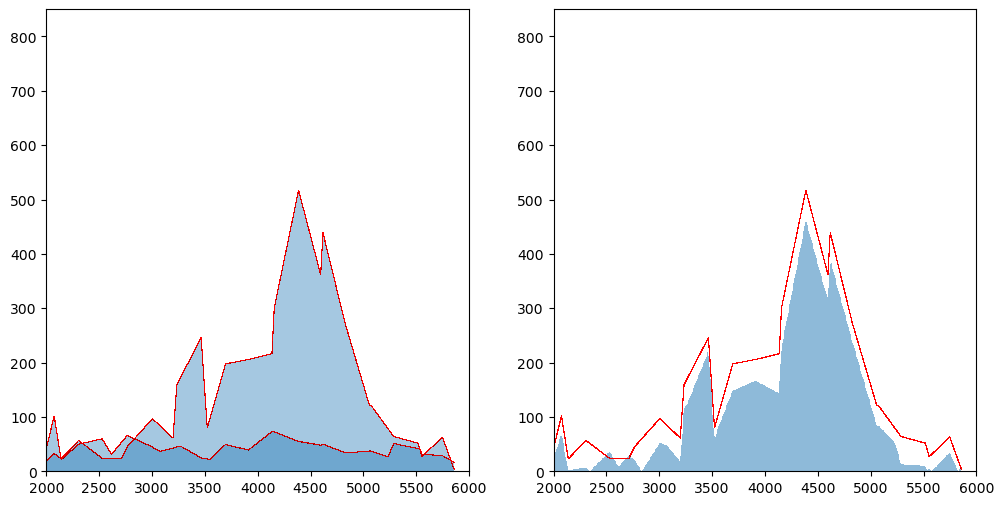

In [66]:
# now we want to plot the difference between the bins describing two different spectral distribution

ch_0 = y_approx[0][1]  # first ts of channel 0 and 1; without make a difference for the area, it is possible to consider mismatch between bins height
ch_1 = y_approx[1][1]
h_diff = []
area_diff = []

prove = 1
channel = 0

xlim = [start_interval,finish_interval]
ylim = [0, 850]
for k in range(len(ch_0)):
    area_diff.append(np.abs(ch_0[k]-ch_1[k])*(x_axis[k+1]-x_axis[k]))
    h_diff.append(np.abs(ch_0[k]-ch_1[k]))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plt.setp(ax, xlim=xlim, ylim=ylim)

for t in range(len(x_axis)-1):
    
    ax[0].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], y_approx[channel][prove][t], alpha=0.4))
    ax[0].plot(appr_x[channel][prove], max_points[channel][prove], color='red', alpha=0.2, linewidth=0.1)
    ax[0].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], y_approx[channel+1][prove][t], alpha=0.4))
    ax[0].plot(appr_x[channel+1][prove], max_points[channel+1][prove], color='red', alpha=0.2, linewidth=0.1)
    ax[1].plot(appr_x[channel][prove], max_points[channel][prove], color='red', alpha=0.5, linewidth=0.1)
    ax[1].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], h_diff[t], alpha = 0.5))

plt.show()
# for validation, it is possible to notice that when the two functions intersect on the plot on the right, 
# the error on the function evaluated is zero 

In [67]:
diff_h_list_final = []
diff_area_list_final = []

for i in range(len(y_approx)):
    diff_h_list_ch = []
    diff_area_list_ch = []
    for j in range(len(y_approx[i])):
        ts_h_diff = []
        ts_area_diff = []
        for p in range(len(y_approx)):
            temp_diff = []
            temp_area_diff = []
            
            for k in range(len(y_approx[i][j])):
                temp_diff.append(np.abs(y_approx[i][j][k]-y_approx[p][j][k]))
                temp_area_diff.append(np.abs(y_approx[i][j][k]-y_approx[p][j][k])*(x_axis[k+1]-x_axis[k]))
                
            ts_h_diff.append(temp_diff)
            ts_area_diff.append(temp_area_diff)
            
        diff_h_list_ch.append(ts_h_diff)
        diff_area_list_ch.append(ts_area_diff)
        
    diff_h_list_final.append(diff_h_list_ch)    
    diff_area_list_final.append(diff_area_list_ch)


In [68]:
# checking for errors...

for i in range(len(diff_h_list_final)):
    for j in range(len(diff_h_list_final[i])):
        for k in range(len(diff_h_list_final[i][j])):
            if(diff_area_list_final[i][j][i][k] != 0.0):
                print("error occured: diff_area = {}".format(diff_area_list_final[i][j][i][k]))
                print("error in index: i={}, j={}, k={}". format(i,j,k))
            for p in range(len(diff_h_list_final)):
                if(diff_area_list_final[i][j][p][k] != diff_area_list_final[p][j][i][k]):
                    print("error!")                

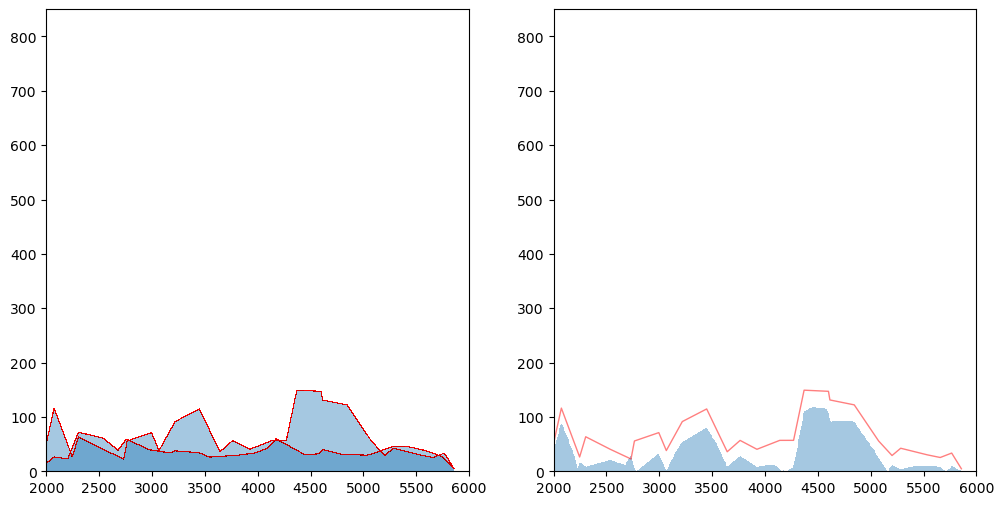

In [69]:
# testing...
prove = 110
channel1 = 0
channel2 = 1

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plt.setp(ax, xlim=xlim, ylim=ylim)
ax[1].plot(appr_x[channel][prove], max_points[channel][prove], color='red', alpha=0.5, linewidth=1)
for t in range(len(x_axis)-1):
 
    ax[0].plot(appr_x[channel][prove], max_points[channel][prove], color='red', alpha=0.2, linewidth=0.1)
    ax[0].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], y_approx[channel2][prove][t], alpha=0.4))
    ax[0].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], y_approx[channel][prove][t], alpha=0.4))
    ax[0].plot(appr_x[channel2][prove], max_points[channel2][prove], color='red', alpha=0.2, linewidth=0.1)
    ax[1].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], diff_h_list_final[channel][prove][channel2][t], alpha=0.4))
    
    #ax[1].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], h_diff[t], alpha = 0.5))

plt.show()

In [70]:
# metrics definition and normalization
diff_integral_list = []
for i in range(len(diff_area_list_final)):
    diff_integral_ch = []
    for j in range(len(diff_area_list_final[i])):
        diff_integral_ts = []
        for k in range(len(diff_area_list_final[i][j])):
            diff_integral_ts.append((sum(diff_area_list_final[i][j][k]))/bins_approximation)   # normalization for the number of bins 
        diff_integral_ch.append(sum(diff_integral_ts)/3)     # 4 represent the number of channel
    diff_integral_list.append(diff_integral_ch)     

 
for j in range(len(diff_integral_list[0])):
    value_list = [diff_integral_list[0][j], diff_integral_list[1][j], diff_integral_list[2][j], diff_integral_list[3][j]]
    min_value = min(value_list)
    for k in range(len(diff_integral_list)):
        diff_integral_list[k][j] = diff_integral_list[k][j] / min_value

In [72]:
# features matrix description and 1-D Kmeans clustering
X = []
zero_set = []
one_set = []
good_X = []
bad_X = []
for i in range(len(diff_integral_list)):
    for j in range(len(diff_integral_list[i])):
        X.append(diff_integral_list[i][j])
        
clusters, centroids = kmeans1d.cluster(X, 2)
clusters_split = np.split(np.array(clusters), 4)

half_centroid = (centroids[0]+centroids[1])/2

for p in range(len(clusters)):
    if(clusters[p]== 0):
        zero_set.append([p, X[p]])
    else:
        one_set.append([p, X[p]])
    
        
one_set = np.array(one_set).reshape(-1,2)
zero_set = np.array(zero_set).reshape(-1,2)

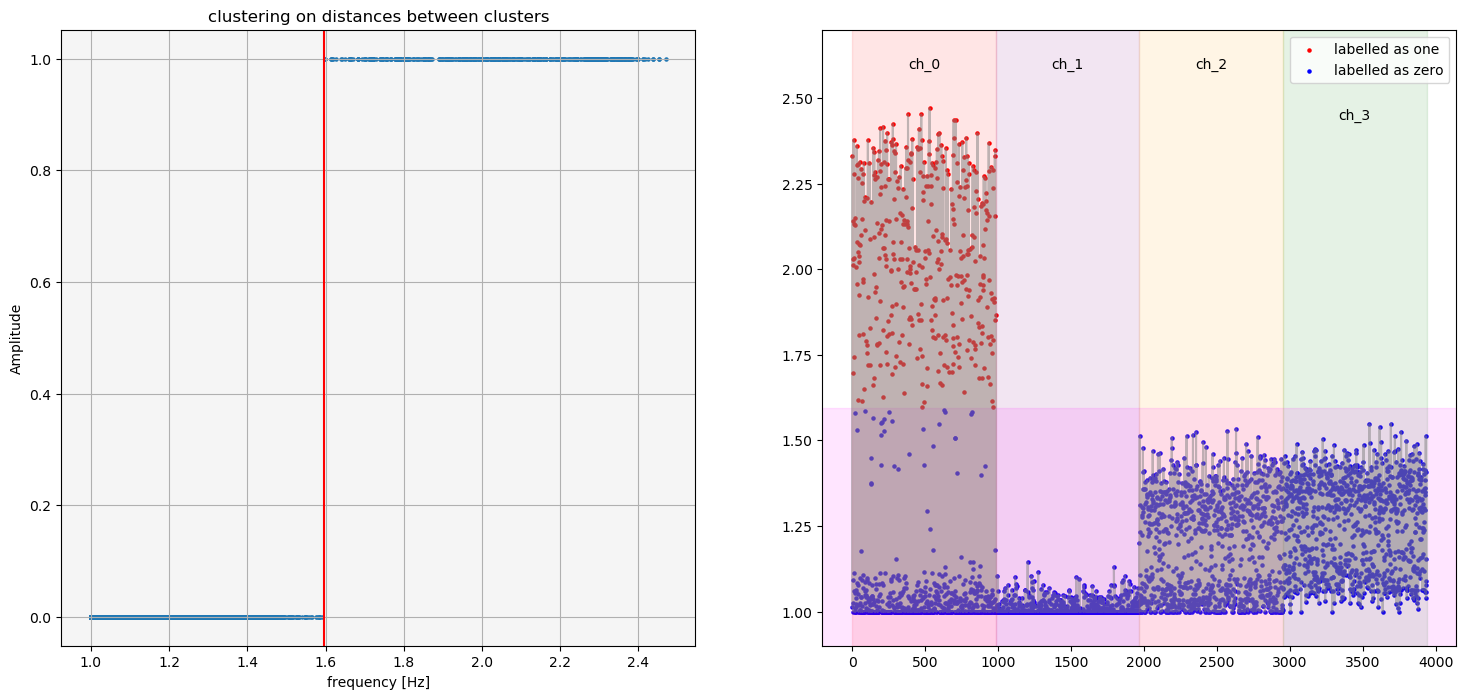

In [73]:
# plotting stuff for final clustering result
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

ax[0].scatter(X, clusters, s = 5, alpha= 1)
ax[0].axvline(x = half_centroid, color = 'red', label = 'axvline - full height')
ax[1].plot(X, alpha=0.5, color='grey')
ax[1].text(984/2, 2.6, 'ch_0', horizontalalignment='center', verticalalignment='center')
ax[1].text(984/2+984, 2.6, 'ch_1', horizontalalignment='center', verticalalignment='center')
ax[1].text(984/2+984*2, 2.6, 'ch_2', horizontalalignment='center', verticalalignment='center')
ax[1].text(984/2+984*3, 2.45, 'ch_3', horizontalalignment='center', verticalalignment='center')
ax[1].axvspan(984*0, 984*1, alpha=0.1, color='red')
ax[1].axvspan(984*1, 984*2, alpha=0.1, color='purple')
ax[1].axvspan(984*2, 984*3, alpha=0.1, color='orange')
ax[1].axvspan(984*3, 984*4, alpha=0.1, color='green')
#ax[1].axhspan(half_centroid, 3000, alpha=0.1, color='green')
ax[1].axhspan(0, half_centroid, alpha=0.1, color='magenta')
ax[1].set_ylim(0.9, 2.7)
ax[1].scatter(one_set[:,0],one_set[:,1], color='red', s=5, label="labelled as one")
ax[1].scatter(zero_set[:,0],zero_set[:,1], color='blue', s=5, label="labelled as zero")

ax[1].legend()
ax[0].set_title("clustering on distances between clusters")
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('Amplitude')
ax[0].grid(True)
ax[0].set_facecolor('whitesmoke')

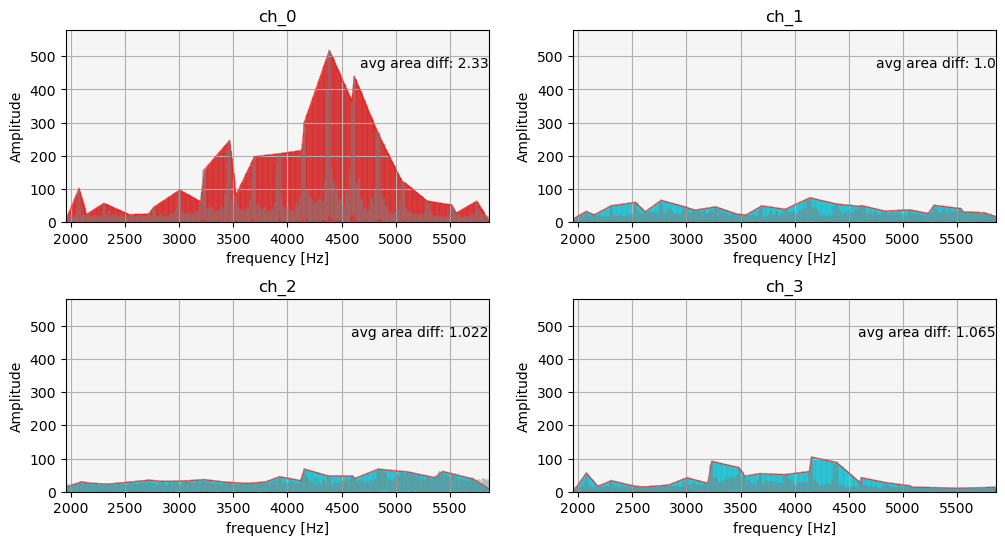

In [76]:
# plotting the visualization for single measurements over the four different accellerometer
ts = 1
xlim2 = [xf_list[0][0][0], xf_list[0][0][len(xf_list[0][0])-1]]
ylim2 = [0, 580]
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace = 0.4)
plt.setp(ax, xlim=xlim2, ylim=ylim2)

ax[0,0].set_title("ch_" + str(0))
ax[0,0].set_xlabel('frequency [Hz]')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].grid(True)
ax[0,0].set_facecolor('whitesmoke')

ax[0,1].set_title("ch_" + str(1))
ax[0,1].set_xlabel('frequency [Hz]')
ax[0,1].set_ylabel('Amplitude')
ax[0,1].grid(True)
ax[0,1].set_facecolor('whitesmoke')

ax[1,0].set_title("ch_" + str(2))
ax[1,0].set_xlabel('frequency [Hz]')
ax[1,0].set_ylabel('Amplitude')
ax[1,0].grid(True)
ax[1,0].set_facecolor('whitesmoke')

ax[1,1].set_title("ch_" + str(3))
ax[1,1].set_xlabel('frequency [Hz]')
ax[1,1].set_ylabel('Amplitude')
ax[1,1].grid(True)
ax[1,1].set_facecolor('whitesmoke')

ax[0,0].plot(appr_x[0][ts], max_points[0][ts], color='red', alpha=0.6, linewidth=1)
ax[0,0].text(xf_list[0][0][len(xf_list[0][0])-1], 500, 'avg area diff: ' + str(round(diff_integral_list[0][ts], 3)), ha='right', va='top')
ax[0,1].text(xf_list[0][0][len(xf_list[0][0])-1], 500, 'avg area diff: ' + str(round(diff_integral_list[1][ts], 3)), ha='right', va='top')
ax[1,0].text(xf_list[0][0][len(xf_list[0][0])-1], 500, 'avg area diff: ' + str(round(diff_integral_list[2][ts], 3)), ha='right', va='top')
ax[1,1].text(xf_list[0][0][len(xf_list[0][0])-1], 500, 'avg area diff: ' + str(round(diff_integral_list[3][ts], 3)), ha='right', va='top')
ax[0,1].plot(appr_x[1][ts], max_points[1][ts], color='red', alpha=0.6, linewidth=1)
ax[1,0].plot(appr_x[2][ts], max_points[2][ts], color='red', alpha=0.6, linewidth=1)
ax[1,1].plot(appr_x[3][ts], max_points[3][ts], color='red', alpha=0.6, linewidth=1)
ax[0,0].plot(xf_list[0][ts], yf_list[0][ts], color='gray', alpha=0.5)
ax[0,1].plot(xf_list[1][ts], yf_list[1][ts], color='gray', alpha=0.5)
ax[1,0].plot(xf_list[2][ts], yf_list[2][ts], color='gray', alpha=0.5)
ax[1,1].plot(xf_list[3][ts], yf_list[3][ts], color='gray', alpha=0.5)

for t in range(len(x_axis)-1):
    
    if(clusters_split[0][ts] == 0):
        ax[0,0].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], y_approx[0][ts][t], alpha=0.5, color = 'tab:cyan'))
    else: 
        ax[0,0].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], y_approx[0][ts][t], alpha=0.5, color = 'tab:red'))
        
    if(clusters_split[1][ts] == 0):
        ax[0,1].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], y_approx[1][ts][t], alpha=0.5, color = 'tab:cyan'))
    else: 
        ax[0,1].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], y_approx[1][ts][t], alpha=0.5, color = 'tab:red'))
        
    if(clusters_split[2][ts] == 0):
        ax[1,0].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], y_approx[2][ts][t], alpha=0.5, color = 'tab:cyan'))
    else: 
        ax[1,0].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], y_approx[2][ts][t], alpha=0.5, color = 'tab:red'))
        
    if(clusters_split[3][ts] == 0):
        ax[1,1].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], y_approx[3][ts][t], alpha=0.5, color = 'tab:cyan'))
    else: 
        ax[1,1].add_patch(Rectangle((x_axis[t],0), x_axis[t+1] - x_axis[t], y_approx[3][ts][t], alpha=0.5, color = 'tab:red'))
    